### 分析流程：
* 1、加载数据
* 2、探索数据，采用数据可视化的方式更直观展示数据，比如了解信用卡违约率和不违约率人数
* 3、因为数据没有专门测试集，需要使用train_test_split划分数据集
* 4、使用Pipeline管道机制，将数据规范化设置为第一步，分类为第二步
* 5、因为不知道采用哪个分类器效果好，需要使用多个分类器，比如SVM、决策树、随机森林和KNN
* 6、通过GridSearchCV工具，找到每个分类器的最优参数和最优准确率，找到最适合这个项目的分类器和该分类器的参数

In [197]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler  # 数据规范化
from sklearn.pipeline import Pipeline      # 管道机制
from sklearn.metrics import accuracy_score # 计算模型精确度
from sklearn.svm import SVC # 支持向量机
from sklearn.tree import DecisionTreeClassifier # 决策树分类
from sklearn.ensemble import RandomForestClassifier # 随机森林
from sklearn.neighbors import KNeighborsClassifier # KNN
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [34]:
#数据加载
data = pd.read_csv('E:/Jupyter/算法/data/39.credit_default-master/UCI_Credit_Card.csv')
# 显示所有字段
pd.set_option('display.max_columns',None)
display(data.head())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [14]:
# 探索数据
print(data.shape) # 查看数据集大小，30000行数据，有25列
print('-'*100)
#print(data.describe())
print(data.info())

(30000, 25)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_

In [15]:
# 查看下一个月违约率的情况 1：违约，0：守约
next_month = data['default.payment.next.month'].value_counts()
print(next_month)

0    23364
1     6636
Name: default.payment.next.month, dtype: int64


In [18]:
# 违约情况可视化
df = pd.DataFrame({'下一个月违约率':next_month.index,'数量':next_month.values})
df

,下一个月违约率,数量
0,0,23364
1,1,6636


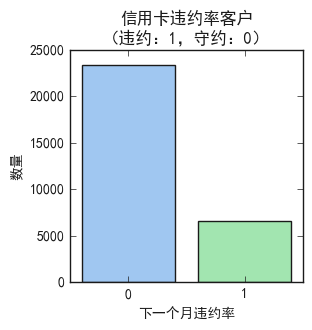

In [31]:
# 显示正常中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize = (3,3))
plt.title('信用卡违约率客户\n（违约：1，守约：0）')
sns.barplot(x = '下一个月违约率',y = '数量',data = df)
# 设置颜色
sns.set_color_codes('pastel')
plt.show()

In [35]:
# 特征选择，去掉ID字段
data.drop(['ID'],axis = 1,inplace = True)
data.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [76]:
# 获取 default.payment.next.month 的值
target = data['default.payment.next.month'].values
display(target)

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [82]:
# 获取第一列到倒数第二列的列名
cc = list(data.columns[0:-1])
display(cc)
# 获取第一列到倒数第二列的值
features = data[cc].values
display(features)

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

array([[  2.00000000e+04,   2.00000000e+00,   2.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.20000000e+05,   2.00000000e+00,   2.00000000e+00, ...,
          1.00000000e+03,   0.00000000e+00,   2.00000000e+03],
       [  9.00000000e+04,   2.00000000e+00,   2.00000000e+00, ...,
          1.00000000e+03,   1.00000000e+03,   5.00000000e+03],
       ..., 
       [  3.00000000e+04,   1.00000000e+00,   2.00000000e+00, ...,
          4.20000000e+03,   2.00000000e+03,   3.10000000e+03],
       [  8.00000000e+04,   1.00000000e+00,   3.00000000e+00, ...,
          1.92600000e+03,   5.29640000e+04,   1.80400000e+03],
       [  5.00000000e+04,   1.00000000e+00,   2.00000000e+00, ...,
          1.00000000e+03,   1.00000000e+03,   1.00000000e+03]])

In [196]:
# 30%的值作为测试集，其余作为训练集
# random_state：是随机数的种子。
# 随机数种子：其实就是该组随机数的编号，在需要重复试验的时候，保证得到一组一样的随机数。
# 比如你每次都填1，其他参数一样的情况下你得到的随机数组是一样的。但不填的话，每次都会不一样。
# 将stratify = X 就是按照X中的比例分配
train_x,test_x,train_y,test_y = train_test_split(features,target,test_size = 0.3,random_state = 1,stratify = target)
print(len(train_x))
print(len(test_x))

21000
9000


In [199]:
# 构造各种分类器
classifiers = [
    SVC(random_state = 1,kernel = 'rbf'),  # 支持向量机，默认rbf：高斯核函数
    DecisionTreeClassifier(random_state = 1,criterion = 'gini'), # 决策树分类
    RandomForestClassifier(random_state = 1,criterion = 'gini'), # 随机森林
    KNeighborsClassifier(metric = 'minkowski')
]

In [204]:
# 分类器名称
classifier_names = [
    'svc',
    'decisiontreeclassifier',
    'randomforestclassifier',
    'kneighborsclassifier'
]

In [205]:
# 分类器参数
classifier_parm_grid = [
    {'svc__C':[1],'svc__gamma':[0.01]},
    {'decisiontreeclassifier__max_depth':[6,9,11]},    # 设置了3种最大深度
    {'randomforestclassifier__n_estimators':[3,5,6]},  # 设置了3个决策树个数
    {'kneighborsclassifier__n_neighbors':[4,6,8]}      # 设置了3个n的取值
]

In [213]:
# 对具体的分类器进行GridSearchCV参数调优
def GridSearchCV_work(pipeline,train_x,train_y,test_x,test_y,param_grid,score = 'accuracy'):

    #estimator：代表我们想采用的分类器，比如随机森林、决策树、SVM、KNN等
    #param_grid：代表我们想要优化的参数及取值，输入的是字典或列表形式
    #scoring：准确度的评价标准，默认None，也是需要使用score函数。也可以设置具体的评价标准，比如accuray，f1等
    #cv：交叉验证的折数，默认None，代表使用三折交叉验证。
    #(You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.)---给cv指定一个值而不是依赖默认值，在0.22版本中，默认值将从3更改为5
    gridsearch = GridSearchCV(estimator = pipeline,param_grid = param_grid,scoring = score,cv = 5)  
    
    # 寻找最优的参数和最优的准确率
    search = gridsearch.fit(train_x,train_y)
    print('GridSearch最优参数：',search.best_params_)
    print('GridSearch最优准确率：%.4f' %search.best_score_)
    predict_y = gridsearch.predict(test_x)
    print('准确率：%.4f' %accuracy_score(test_y,predict_y))
    print('-'*100)

In [214]:
for model,model_name,model_param_grid in zip(classifiers,classifier_names,classifier_parm_grid):
    pipeline = Pipeline([
            ('scaler',StandardScaler()),  #数据规范化
            (model_name,model)
        ])
    result = GridSearchCV_work(pipeline,train_x,train_y,test_x,test_y,model_param_grid,score = 'accuracy')

GridSearch最优参数： {'svc__gamma': 0.01, 'svc__C': 1}
GridSearch最优准确率：0.8186
准确率：0.8172
----------------------------------------------------------------------------------------------------
GridSearch最优参数： {'decisiontreeclassifier__max_depth': 6}
GridSearch最优准确率：0.8208
准确率：0.8113
----------------------------------------------------------------------------------------------------
GridSearch最优参数： {'randomforestclassifier__n_estimators': 6}
GridSearch最优准确率：0.8004
准确率：0.7994
----------------------------------------------------------------------------------------------------
GridSearch最优参数： {'kneighborsclassifier__n_neighbors': 8}
GridSearch最优准确率：0.8040
准确率：0.8036
----------------------------------------------------------------------------------------------------
